# Benchmark GPU vs CPU para Cadenas de Markov

Este notebook compara el rendimiento entre implementaciones CPU (NumPy) y GPU (CuPy) para calcular distribuciones estacionarias.

**Métodos comparados:**
- **Método 1**: Vectores propios
- **Método 2**: Tiempo medio de retorno

**Beneficios de GPU:**
- Paralelización masiva de operaciones matriciales
- Aceleración significativa para matrices grandes
- Misma precisión que CPU

In [1]:
import sys
import os
sys.path.append(os.path.join(os.path.dirname('__file__'), '..'))

from src.markov_matrix import (
    crear_matriz_probabilidad,
    calcular_distribucion_metodo_autovalores,
    calcular_distribucion_metodo_tiempo_retorno,
    GPU_AVAILABLE
)

if GPU_AVAILABLE:
    from src.markov_matrix import (
        calcular_distribucion_metodo_autovalores_gpu,
        calcular_distribucion_metodo_tiempo_retorno_gpu
    )
    import cupy as cp

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

print(f"GPU disponible: {GPU_AVAILABLE}")
if GPU_AVAILABLE:
    print(f"GPU: {cp.cuda.runtime.getDeviceProperties(0)['name'].decode()}")
    print(f"Memoria GPU: {cp.cuda.runtime.getDeviceProperties(0)['totalGlobalMem'] // 1024**3} GB")

❌ CuPy instalado pero faltan librerías CUDA
💡 Instale CUDA Toolkit completo o use modo CPU
💡 Alternativa: ejecute en Google Colab o entorno con CUDA completo
🔄 Usando solo cálculos en CPU
GPU disponible: False


## Ejemplo Básico: Comparación CPU vs GPU

In [2]:
# Parámetros de ejemplo
n = 100  # número de estados
p = 0.6   # probabilidad

# Crear matriz
matriz = crear_matriz_probabilidad(n, p)

print(f"Matriz de {n}x{n} con p={p}")

# CPU - Método 1
start = time.time()
pi1_cpu = calcular_distribucion_metodo_autovalores(matriz)
t1_cpu = time.time() - start

# CPU - Método 2
start = time.time()
pi2_cpu = calcular_distribucion_metodo_tiempo_retorno(matriz)
t2_cpu = time.time() - start

print(f"\nResultados CPU:")
print(f"Método 1: {t1_cpu:.6f}s")
print(f"Método 2: {t2_cpu:.6f}s")

if GPU_AVAILABLE:
    # GPU - Método 1
    start = time.time()
    pi1_gpu = calcular_distribucion_metodo_autovalores_gpu(matriz)
    t1_gpu = time.time() - start
    
    # GPU - Método 2
    start = time.time()
    pi2_gpu = calcular_distribucion_metodo_tiempo_retorno_gpu(matriz)
    t2_gpu = time.time() - start
    
    print(f"\nResultados GPU:")
    print(f"Método 1: {t1_gpu:.6f}s (speedup: {t1_cpu/t1_gpu:.2f}x)")
    print(f"Método 2: {t2_gpu:.6f}s (speedup: {t2_cpu/t2_gpu:.2f}x)")
    
    # Verificar precisión
    error1 = np.max(np.abs(pi1_cpu - pi1_gpu))
    error2 = np.max(np.abs(pi2_cpu - pi2_gpu))
    
    print(f"\nPrecisión:")
    print(f"Error máximo Método 1: {error1:.2e}")
    print(f"Error máximo Método 2: {error2:.2e}")
else:
    print("\nGPU no disponible - instale CuPy para usar GPU")

Matriz de 100x100 con p=0.6

Resultados CPU:
Método 1: 0.002573s
Método 2: 0.017020s

GPU no disponible - instale CuPy para usar GPU


## Benchmark Completo: Múltiples Tamaños de Matriz

In [3]:
# Parámetros del benchmark
tamaños = [50, 100, 200, 500, 1000]
p = 0.6
repeticiones = 3

resultados = []

print("Ejecutando benchmark...")
print("Tamaño | CPU Método 1 | GPU Método 1 | Speedup | CPU Método 2 | GPU Método 2 | Speedup")
print("-" * 85)

for n in tamaños:
    matriz = crear_matriz_probabilidad(n, p)
    
    # CPU - Método 1
    tiempos_cpu_1 = []
    for _ in range(repeticiones):
        start = time.time()
        pi = calcular_distribucion_metodo_autovalores(matriz)
        tiempos_cpu_1.append(time.time() - start)
    t1_cpu = np.mean(tiempos_cpu_1)
    
    # CPU - Método 2
    tiempos_cpu_2 = []
    for _ in range(repeticiones):
        start = time.time()
        pi = calcular_distribucion_metodo_tiempo_retorno(matriz)
        tiempos_cpu_2.append(time.time() - start)
    t2_cpu = np.mean(tiempos_cpu_2)
    
    if GPU_AVAILABLE:
        # GPU - Método 1
        tiempos_gpu_1 = []
        for _ in range(repeticiones):
            start = time.time()
            pi = calcular_distribucion_metodo_autovalores_gpu(matriz)
            tiempos_gpu_1.append(time.time() - start)
        t1_gpu = np.mean(tiempos_gpu_1)
        
        # GPU - Método 2
        tiempos_gpu_2 = []
        for _ in range(repeticiones):
            start = time.time()
            pi = calcular_distribucion_metodo_tiempo_retorno_gpu(matriz)
            tiempos_gpu_2.append(time.time() - start)
        t2_gpu = np.mean(tiempos_gpu_2)
        
        s1 = t1_cpu / t1_gpu
        s2 = t2_cpu / t2_gpu
        
        print(f"{n:4d}   | {t1_cpu:8.4f}s   | {t1_gpu:8.4f}s   | {s1:5.2f}x  | {t2_cpu:8.4f}s   | {t2_gpu:8.4f}s   | {s2:5.2f}x")
        
        resultados.append({
            'n': n,
            'cpu_metodo1': t1_cpu,
            'gpu_metodo1': t1_gpu,
            'speedup_metodo1': s1,
            'cpu_metodo2': t2_cpu,
            'gpu_metodo2': t2_gpu,
            'speedup_metodo2': s2
        })
    else:
        print(f"{n:4d}   | {t1_cpu:8.4f}s   |    N/A     |  N/A   | {t2_cpu:8.4f}s   |    N/A     |  N/A")
        
        resultados.append({
            'n': n,
            'cpu_metodo1': t1_cpu,
            'gpu_metodo1': None,
            'speedup_metodo1': None,
            'cpu_metodo2': t2_cpu,
            'gpu_metodo2': None,
            'speedup_metodo2': None
        })

df_resultados = pd.DataFrame(resultados)

Ejecutando benchmark...
Tamaño | CPU Método 1 | GPU Método 1 | Speedup | CPU Método 2 | GPU Método 2 | Speedup
-------------------------------------------------------------------------------------
  50   |   0.0008s   |    N/A     |  N/A   |   0.0023s   |    N/A     |  N/A
 100   |   0.0017s   |    N/A     |  N/A   |   0.0073s   |    N/A     |  N/A
 200   |   0.0231s   |    N/A     |  N/A   |   0.0594s   |    N/A     |  N/A
 500   |   0.1281s   |    N/A     |  N/A   |   0.2855s   |    N/A     |  N/A
1000   |   0.5568s   |    N/A     |  N/A   |   5.6944s   |    N/A     |  N/A


## Visualización de Resultados

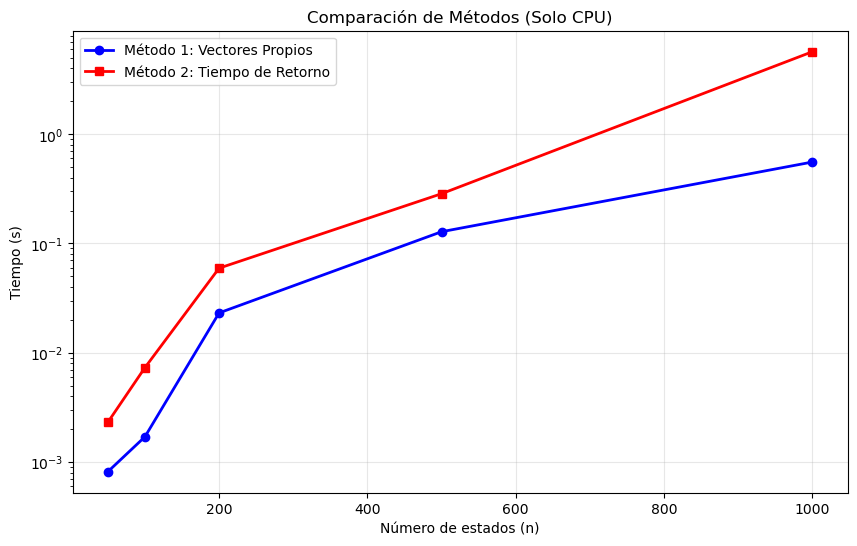


Para usar aceleración GPU, instale CuPy:
pip install cupy-cuda11x  # para CUDA 11.x
pip install cupy-cuda12x  # para CUDA 12.x


In [4]:
if GPU_AVAILABLE:
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Gráfico 1: Tiempos de ejecución Método 1
    ax1.plot(df_resultados['n'], df_resultados['cpu_metodo1'], 'b-o', label='CPU', linewidth=2)
    ax1.plot(df_resultados['n'], df_resultados['gpu_metodo1'], 'r-s', label='GPU', linewidth=2)
    ax1.set_xlabel('Número de estados (n)')
    ax1.set_ylabel('Tiempo (s)')
    ax1.set_title('Método 1: Vectores Propios')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_yscale('log')
    
    # Gráfico 2: Tiempos de ejecución Método 2
    ax2.plot(df_resultados['n'], df_resultados['cpu_metodo2'], 'b-o', label='CPU', linewidth=2)
    ax2.plot(df_resultados['n'], df_resultados['gpu_metodo2'], 'r-s', label='GPU', linewidth=2)
    ax2.set_xlabel('Número de estados (n)')
    ax2.set_ylabel('Tiempo (s)')
    ax2.set_title('Método 2: Tiempo de Retorno')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_yscale('log')
    
    # Gráfico 3: Speedups
    ax3.plot(df_resultados['n'], df_resultados['speedup_metodo1'], 'g-o', label='Método 1', linewidth=2)
    ax3.plot(df_resultados['n'], df_resultados['speedup_metodo2'], 'm-s', label='Método 2', linewidth=2)
    ax3.axhline(y=1, color='k', linestyle='--', alpha=0.5, label='Sin aceleración')
    ax3.set_xlabel('Número de estados (n)')
    ax3.set_ylabel('Speedup (veces más rápido)')
    ax3.set_title('Aceleración GPU vs CPU')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Gráfico 4: Comparación de métodos
    cpu_ratio = df_resultados['cpu_metodo2'] / df_resultados['cpu_metodo1']
    gpu_ratio = df_resultados['gpu_metodo2'] / df_resultados['gpu_metodo1']
    ax4.plot(df_resultados['n'], cpu_ratio, 'b-o', label='CPU: Método2/Método1', linewidth=2)
    ax4.plot(df_resultados['n'], gpu_ratio, 'r-s', label='GPU: Método2/Método1', linewidth=2)
    ax4.axhline(y=1, color='k', linestyle='--', alpha=0.5, label='Igual velocidad')
    ax4.set_xlabel('Número de estados (n)')
    ax4.set_ylabel('Ratio de tiempos')
    ax4.set_title('Comparación entre Métodos')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Estadísticas finales
    print(f"\nRESUMEN DE RENDIMIENTO:")
    print(f"Speedup promedio Método 1: {df_resultados['speedup_metodo1'].mean():.2f}x")
    print(f"Speedup promedio Método 2: {df_resultados['speedup_metodo2'].mean():.2f}x")
    print(f"Máximo speedup Método 1:  {df_resultados['speedup_metodo1'].max():.2f}x")
    print(f"Máximo speedup Método 2:  {df_resultados['speedup_metodo2'].max():.2f}x")

else:
    plt.figure(figsize=(10, 6))
    plt.plot(df_resultados['n'], df_resultados['cpu_metodo1'], 'b-o', label='Método 1: Vectores Propios', linewidth=2)
    plt.plot(df_resultados['n'], df_resultados['cpu_metodo2'], 'r-s', label='Método 2: Tiempo de Retorno', linewidth=2)
    plt.xlabel('Número de estados (n)')
    plt.ylabel('Tiempo (s)')
    plt.title('Comparación de Métodos (Solo CPU)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.yscale('log')
    plt.show()
    
    print("\nPara usar aceleración GPU, instale CuPy:")
    print("pip install cupy-cuda11x  # para CUDA 11.x")
    print("pip install cupy-cuda12x  # para CUDA 12.x")

In [5]:
# Guardar resultados
df_resultados.to_csv('benchmark_gpu_results.csv', index=False)
print("Resultados guardados en: benchmark_gpu_results.csv")

# Mostrar tabla de resultados
print("\nTabla de resultados:")
display(df_resultados)

Resultados guardados en: benchmark_gpu_results.csv

Tabla de resultados:


,n,cpu_metodo1,gpu_metodo1,speedup_metodo1,cpu_metodo2,gpu_metodo2,speedup_metodo2
0,50,0.000814,None,None,0.002307,None,None
1,100,0.001699,None,None,0.007302,None,None
2,200,0.023140,None,None,0.059434,None,None
3,500,0.128127,None,None,0.285498,None,None
4,1000,0.556814,None,None,5.694423,None,None
